In [1]:
#imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sns.set_style('darkgrid')

import xgboost
import sklearn
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import tree
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
import re

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [2]:
print(xgboost.__version__)

0.90


In [3]:
print(sklearn.__version__)

0.22.2.post1


In [5]:
cenarios = pd.read_csv('./data/cenarios_expansao.csv')

faturamento = pd.read_csv('./data/faturamento_lojas_atuais.csv')

lojas = pd.read_csv('./data/lojas_atuais.csv')

In [111]:
# Verificar a correlação entre média de de 2016 e 2017 
grouped_loja_ano_mes = faturamento.groupby(["cod_loja","ano","mes"]).sum().reset_index()
grouped_loja_ano_mes

,cod_loja,ano,mes,qtde,receita
0,1,2016,1,13034.0,441833.37
1,1,2016,2,11411.0,395340.22
2,1,2016,3,15030.0,587810.18
3,1,2016,4,12726.0,534618.84
4,1,2016,5,13978.0,595477.92
...,...,...,...,...,...
73639,3687,2017,8,1864.0,71171.48
73640,3687,2017,9,1257.0,48284.66
73641,3687,2017,10,1709.0,61198.10
73642,3687,2017,11,2039.0,73877.02


In [112]:
grouped_loja_ano_mes['mes_ano'] = grouped_loja_ano_mes[['ano', 'mes']].astype(str).apply(lambda x: '_'.join(x), axis=1)
grouped_loja_ano_mes = grouped_loja_ano_mes.pivot_table("receita",["cod_loja"],["mes_ano"])
grouped_loja_ano_mes

mes_ano,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,2017_11,2017_12,2017_2,2017_3,2017_4,2017_5,2017_6,2017_7,2017_8,2017_9
cod_loja,,,,,,,,,,,,,,,,,,,,,
1,441833.37,611797.30,876921.63,1257613.00,395340.22,587810.18,534618.84,595477.92,589947.05,563814.03,...,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,757850.68,602313.53
2,54660.39,53209.15,53830.14,108589.21,49120.72,53421.91,60167.41,89412.94,68925.00,69741.67,...,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,72463.56,64936.11
3,161428.96,198425.47,199192.78,422565.37,132417.93,139495.61,147895.60,210103.96,173810.84,137311.66,...,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,173861.61,142303.83
4,54363.21,41540.57,57029.49,168548.71,38433.23,43751.17,38245.63,66096.71,60945.98,45347.35,...,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,58756.90,50140.08
5,248834.01,219199.82,250667.71,431426.39,182297.02,210579.83,202545.65,343893.54,256717.01,223261.58,...,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,220496.40,179435.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,121727.10,135680.82,165448.69,308765.74,96526.36,150817.29,135871.79,184258.56,149133.42,137734.89,...,170958.84,318682.59,105736.48,132543.17,123296.83,187709.03,169697.42,129052.07,164097.51,135871.52
3683,190014.89,146891.10,198892.84,323886.18,107871.65,125584.12,139183.52,183725.95,179220.60,128065.87,...,202219.10,273599.44,129491.36,130658.08,121326.66,183987.96,182052.22,117836.80,181790.37,146123.72
3685,187775.61,168270.33,203865.09,462640.41,145430.99,184151.12,153812.76,230982.85,195695.55,155068.66,...,205311.91,427705.10,125240.48,192202.86,175195.33,258223.27,238821.98,169798.69,231486.83,152709.19


### Usando somente os meses

In [9]:
removed_nan = grouped_loja_ano_mes.dropna(0,subset=["2017_1"])

In [10]:
features = ['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9']
X = removed_nan[features].fillna(0)
target = ['2017_1']
Y = removed_nan[target]

In [11]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [12]:
model_jan = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)

In [13]:
score = cross_val_score(model_jan, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [120.58362847 125.6036924  148.9295192  128.22537903 125.09534788]
Mean: 129.68751339652724
Standard deviation: 9.93014524587887


In [14]:
model_jan = model_jan.fit(X_train, y_train)
y_pred = model_jan.predict(X_test)
mean_squared_error(y_test,y_pred)

276065592.6592041

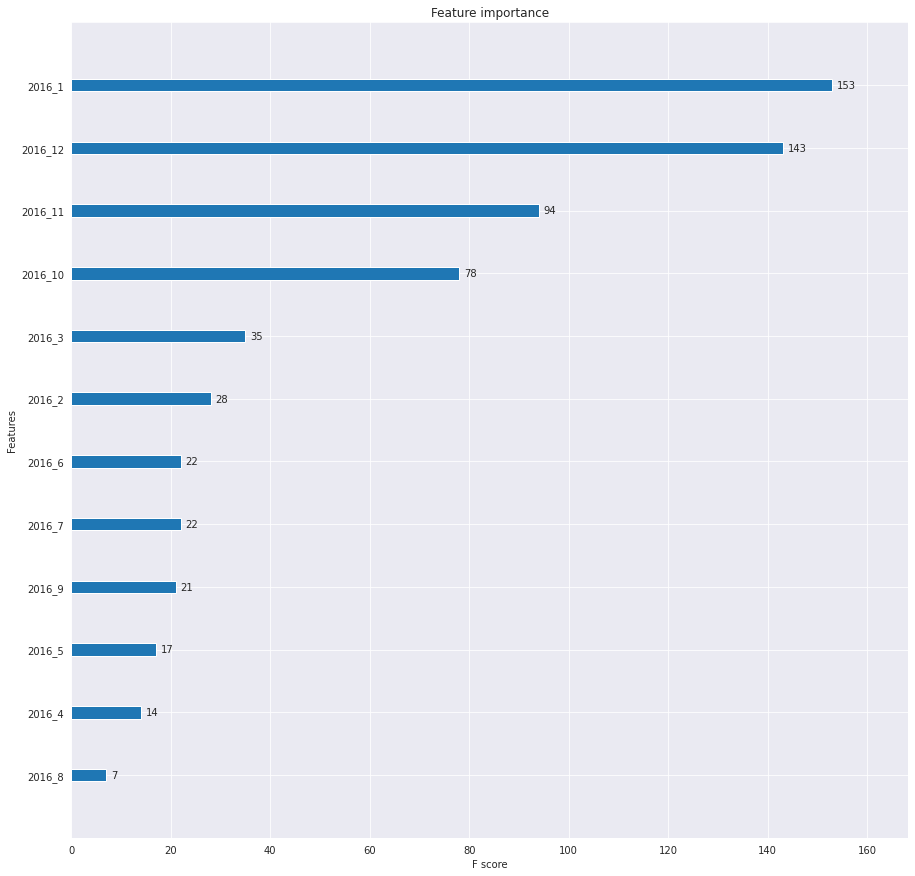

In [271]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_jan, ax=ax)
plt.show()


In [18]:
feature_01_dummy = pd.get_dummies(lojas.feature_01)
feature_02_dummy = pd.get_dummies(lojas.feature_02)
feature_05_dummy = pd.get_dummies(lojas.feature_05)
feature_11_dummy = pd.get_dummies(lojas.feature_11)
feature_12_dummy = pd.get_dummies(lojas.feature_12)
hot_encoded_lojas = pd.concat([lojas,feature_01_dummy,feature_02_dummy,feature_05_dummy,feature_11_dummy,feature_12_dummy],axis=1)
hot_encoded_lojas

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,...,FEATURE_05_VALUE_08,FEATURE_11_VALUE_01,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02
0,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,...,0,0,0,0,0,0,0,0,0,0
1,2,5300108005004,5300108,NaN,FEATURE_02_VALUE_03,True,22.00,FEATURE_05_VALUE_03,27,0.215967,...,0,0,0,0,0,0,0,0,0,0
2,3,3550308005052,3550308,NaN,FEATURE_02_VALUE_03,True,45.66,FEATURE_05_VALUE_03,6,0.190102,...,0,0,0,0,0,0,0,0,0,0
3,4,3145604003002,3145604,NaN,FEATURE_02_VALUE_04,False,30.00,FEATURE_05_VALUE_03,3,0.141988,...,0,0,0,0,0,0,0,0,0,0
4,5,1600303005010,1600303,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,False,62.49,FEATURE_05_VALUE_03,30,0.107619,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,3682,5105259003002,5105259,NaN,FEATURE_02_VALUE_04,False,30.16,FEATURE_05_VALUE_03,5,0.210289,...,0,0,0,0,0,0,0,0,0,0
3126,3683,2604106003003,2604106,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,False,38.00,FEATURE_05_VALUE_03,13,0.146264,...,0,0,0,0,0,0,0,0,0,0
3127,3685,4115804003002,4115804,NaN,FEATURE_02_VALUE_04,False,44.04,FEATURE_05_VALUE_02,7,0.226926,...,0,0,0,0,0,0,0,0,0,0
3128,3686,3509700003001,3509700,NaN,FEATURE_02_VALUE_06,False,31.76,FEATURE_05_VALUE_03,4,0.134354,...,0,0,0,0,0,0,0,0,0,0


In [19]:
hot_encoded_lojas = hot_encoded_lojas.drop(columns=["feature_01","feature_02","feature_05","feature_11","feature_12"])
hot_encoded_lojas

,cod_loja,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,...,FEATURE_05_VALUE_08,FEATURE_11_VALUE_01,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02
0,1,4125506005002,4125506,True,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0,0,0,0,0,0,0,0,0,0
1,2,5300108005004,5300108,True,22.00,27,0.215967,0.197287,1562.674817,3.670883,...,0,0,0,0,0,0,0,0,0,0
2,3,3550308005052,3550308,True,45.66,6,0.190102,0.179140,5593.905463,2.815883,...,0,0,0,0,0,0,0,0,0,0
3,4,3145604003002,3145604,False,30.00,3,0.141988,0.143677,12.824022,7.218132,...,0,0,0,0,0,0,0,0,0,0
4,5,1600303005010,1600303,False,62.49,30,0.107619,0.103083,325.531120,1.972944,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,3682,5105259003002,5105259,False,30.16,5,0.210289,0.167499,36.397933,3.491315,...,0,0,0,0,0,0,0,0,0,0
3126,3683,2604106003003,2604106,False,38.00,13,0.146264,0.152495,163.567629,2.016780,...,0,0,0,0,0,0,0,0,0,0
3127,3685,4115804003002,4115804,False,44.04,7,0.226926,0.240253,16.862438,4.455832,...,0,0,0,0,0,0,0,0,0,0
3128,3686,3509700003001,3509700,False,31.76,4,0.134354,0.136028,20.565405,3.932982,...,0,0,0,0,0,0,0,0,0,0


In [21]:
grouped_loja_ano_mes["cod_loja"] = grouped_loja_ano_mes.index
grouped_loja_ano_mes.index.names = ["cod_index"]
grouped_loja_ano_mes

mes_ano,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,2017_12,2017_2,2017_3,2017_4,2017_5,2017_6,2017_7,2017_8,2017_9,cod_loja
cod_index,,,,,,,,,,,,,,,,,,,,,
1,441833.37,611797.30,876921.63,1257613.00,395340.22,587810.18,534618.84,595477.92,589947.05,563814.03,...,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,757850.68,602313.53,1
2,54660.39,53209.15,53830.14,108589.21,49120.72,53421.91,60167.41,89412.94,68925.00,69741.67,...,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,72463.56,64936.11,2
3,161428.96,198425.47,199192.78,422565.37,132417.93,139495.61,147895.60,210103.96,173810.84,137311.66,...,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,173861.61,142303.83,3
4,54363.21,41540.57,57029.49,168548.71,38433.23,43751.17,38245.63,66096.71,60945.98,45347.35,...,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,58756.90,50140.08,4
5,248834.01,219199.82,250667.71,431426.39,182297.02,210579.83,202545.65,343893.54,256717.01,223261.58,...,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,220496.40,179435.96,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,121727.10,135680.82,165448.69,308765.74,96526.36,150817.29,135871.79,184258.56,149133.42,137734.89,...,318682.59,105736.48,132543.17,123296.83,187709.03,169697.42,129052.07,164097.51,135871.52,3682
3683,190014.89,146891.10,198892.84,323886.18,107871.65,125584.12,139183.52,183725.95,179220.60,128065.87,...,273599.44,129491.36,130658.08,121326.66,183987.96,182052.22,117836.80,181790.37,146123.72,3683
3685,187775.61,168270.33,203865.09,462640.41,145430.99,184151.12,153812.76,230982.85,195695.55,155068.66,...,427705.10,125240.48,192202.86,175195.33,258223.27,238821.98,169798.69,231486.83,152709.19,3685


In [22]:
hot_encoded_lojas

,cod_loja,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,...,FEATURE_05_VALUE_08,FEATURE_11_VALUE_01,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02
0,1,4125506005002,4125506,True,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0,0,0,0,0,0,0,0,0,0
1,2,5300108005004,5300108,True,22.00,27,0.215967,0.197287,1562.674817,3.670883,...,0,0,0,0,0,0,0,0,0,0
2,3,3550308005052,3550308,True,45.66,6,0.190102,0.179140,5593.905463,2.815883,...,0,0,0,0,0,0,0,0,0,0
3,4,3145604003002,3145604,False,30.00,3,0.141988,0.143677,12.824022,7.218132,...,0,0,0,0,0,0,0,0,0,0
4,5,1600303005010,1600303,False,62.49,30,0.107619,0.103083,325.531120,1.972944,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,3682,5105259003002,5105259,False,30.16,5,0.210289,0.167499,36.397933,3.491315,...,0,0,0,0,0,0,0,0,0,0
3126,3683,2604106003003,2604106,False,38.00,13,0.146264,0.152495,163.567629,2.016780,...,0,0,0,0,0,0,0,0,0,0
3127,3685,4115804003002,4115804,False,44.04,7,0.226926,0.240253,16.862438,4.455832,...,0,0,0,0,0,0,0,0,0,0
3128,3686,3509700003001,3509700,False,31.76,4,0.134354,0.136028,20.565405,3.932982,...,0,0,0,0,0,0,0,0,0,0


In [23]:
data = grouped_loja_ano_mes.merge(hot_encoded_lojas,on="cod_loja")
data 

,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_05_VALUE_08,FEATURE_11_VALUE_01,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02
0,441833.37,611797.30,876921.63,1257613.00,395340.22,587810.18,534618.84,595477.92,589947.05,563814.03,...,0,0,0,0,0,0,0,0,0,0
1,54660.39,53209.15,53830.14,108589.21,49120.72,53421.91,60167.41,89412.94,68925.00,69741.67,...,0,0,0,0,0,0,0,0,0,0
2,161428.96,198425.47,199192.78,422565.37,132417.93,139495.61,147895.60,210103.96,173810.84,137311.66,...,0,0,0,0,0,0,0,0,0,0
3,54363.21,41540.57,57029.49,168548.71,38433.23,43751.17,38245.63,66096.71,60945.98,45347.35,...,0,0,0,0,0,0,0,0,0,0
4,248834.01,219199.82,250667.71,431426.39,182297.02,210579.83,202545.65,343893.54,256717.01,223261.58,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,121727.10,135680.82,165448.69,308765.74,96526.36,150817.29,135871.79,184258.56,149133.42,137734.89,...,0,0,0,0,0,0,0,0,0,0
3126,190014.89,146891.10,198892.84,323886.18,107871.65,125584.12,139183.52,183725.95,179220.60,128065.87,...,0,0,0,0,0,0,0,0,0,0
3127,187775.61,168270.33,203865.09,462640.41,145430.99,184151.12,153812.76,230982.85,195695.55,155068.66,...,0,0,0,0,0,0,0,0,0,0
3128,85259.81,65652.53,89173.66,255149.95,53781.67,49293.02,54453.43,97367.21,91135.64,68652.67,...,0,0,0,0,0,0,0,0,0,0


In [24]:
idh_capita = pd.read_excel('./data/AtlasBrasil_Consulta.xlsx')

municipio = pd.read_excel('./data/municipio.xlsx')

In [25]:
def remove_state(string_data):
  return (re.sub(" \([^)]*\)", "",string_data))

In [26]:
municipio["Territorialidades"] = municipio["Territorialidades"].apply(lambda x: remove_state(x))
municipio.head()

,Territorialidades,População total 2017
0,Brasil,207660929
1,Abadia de Goiás,8207
2,Abadia dos Dourados,7059
3,Abadiânia,18775
4,Abaeté,23611


In [27]:
municipio.columns = ["Espacialidades","População total 2017"]
print(municipio)

                                         Espacialidades População total 2017
0                                                Brasil            207660929
1                                       Abadia de Goiás                 8207
2                                   Abadia dos Dourados                 7059
3                                             Abadiânia                18775
4                                                Abaeté                23611
...                                                 ...                  ...
5563                                            Zé Doca                51084
5564                                             Zortéa                 3300
5565                                                                        
5566  Elaboração: Atlas do Desenvolvimento Humano no...                  NaN
5567  Fontes: dados do IBGE e de registros administr...                  NaN

[5568 rows x 2 columns]


In [28]:
municipio  = municipio.drop_duplicates(subset=["Espacialidades"], keep="last")
municipio

,Espacialidades,População total 2017
0,Brasil,207660929
1,Abadia de Goiás,8207
2,Abadia dos Dourados,7059
3,Abadiânia,18775
4,Abaeté,23611
...,...,...
5563,Zé Doca,51084
5564,Zortéa,3300
5565,,
5566,Elaboração: Atlas do Desenvolvimento Humano no...,NaN


In [29]:
metadata = municipio.merge(idh_capita,on="Espacialidades")
metadata.head()


,Espacialidades,População total 2017,Código,IDHM 2010,IDHM Renda 2010,IDHM Longevidade 2010,Renda per capita 2010
0,Brasil,207660929,76,0.727,0.739,0.816,793.87
1,Abadia de Goiás,8207,5200050,0.708,0.687,0.830,574.96
2,Abadia dos Dourados,7059,3100104,0.689,0.693,0.839,596.18
3,Abadiânia,18775,5200100,0.689,0.671,0.841,519.87
4,Abaeté,23611,3100203,0.698,0.720,0.848,707.24


In [30]:
all_data = data.merge(metadata, how="left", left_on="cod_municipio", right_on="Código")
all_data.head()

,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,Espacialidades,População total 2017,Código,IDHM 2010,IDHM Renda 2010,IDHM Longevidade 2010,Renda per capita 2010
0,441833.37,611797.30,876921.63,1257613.00,395340.22,587810.18,534618.84,595477.92,589947.05,563814.03,...,0,0,0,São José dos Pinhais,307530,4125506.0,0.758,0.749,0.859,846.93
1,54660.39,53209.15,53830.14,108589.21,49120.72,53421.91,60167.41,89412.94,68925.00,69741.67,...,0,0,0,Brasília,3039444,5300108.0,0.824,0.863,0.873,1715.11
2,161428.96,198425.47,199192.78,422565.37,132417.93,139495.61,147895.60,210103.96,173810.84,137311.66,...,0,0,0,São Paulo,12106920,3550308.0,0.805,0.843,0.855,1516.21
3,54363.21,41540.57,57029.49,168548.71,38433.23,43751.17,38245.63,66096.71,60945.98,45347.35,...,0,0,0,Oliveira,41907,3145604.0,0.699,0.691,0.842,588.20
4,248834.01,219199.82,250667.71,431426.39,182297.02,210579.83,202545.65,343893.54,256717.01,223261.58,...,0,1,0,Macapá,474706,1600303.0,0.733,0.723,0.820,717.88


In [68]:
all_data.columns

Index(['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9', '2017_1', '2017_10',
       '2017_11', '2017_12', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6',
       '2017_7', '2017_8', '2017_9', 'cod_loja', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
     

### Usando os meses e os dados de lojas atuais

In [69]:
removed_nan = all_data.dropna(0,subset=["2017_1"])

In [70]:
features = ['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = removed_nan[features]
target = ['2017_1']
Y = removed_nan[target]

In [71]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [72]:
model_jan = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
score = cross_val_score(model_jan, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [118.22040842 126.9666294  147.44993028 125.814051   128.04234847]
Mean: 129.2986735129092
Standard deviation: 9.709330110958527


In [73]:
model_jan = model_jan.fit(X_train, y_train)
y_pred = model_jan.predict(X_test)
mean_squared_error(y_test,y_pred)

228266247.33194846

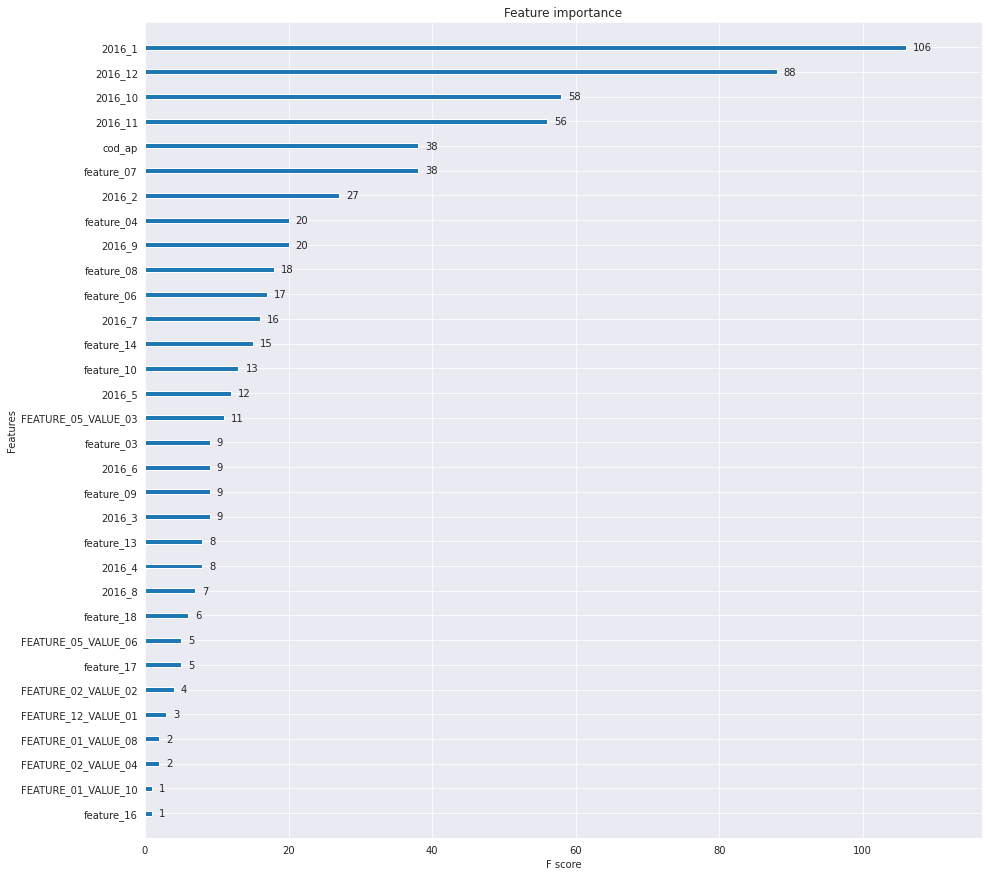

In [74]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_jan, ax=ax)
plt.show()


In [75]:
removed_nan = all_data.dropna(0,subset=["2017_2"])

In [76]:
features = ['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9','2017_1', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = removed_nan[features]
target = ['2017_2']
Y = removed_nan[target]

In [77]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [78]:
model_fev = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
score = cross_val_score(model_fev, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [ 99.98716783 104.7722158  106.00303906 103.51587086 118.53933647]
Mean: 106.56352600360314
Standard deviation: 6.316322710485329


In [79]:
model_fev = model_fev.fit(X_train, y_train)
y_pred = model_fev.predict(X_test)
mean_squared_error(y_test,y_pred)

130242248.15309934

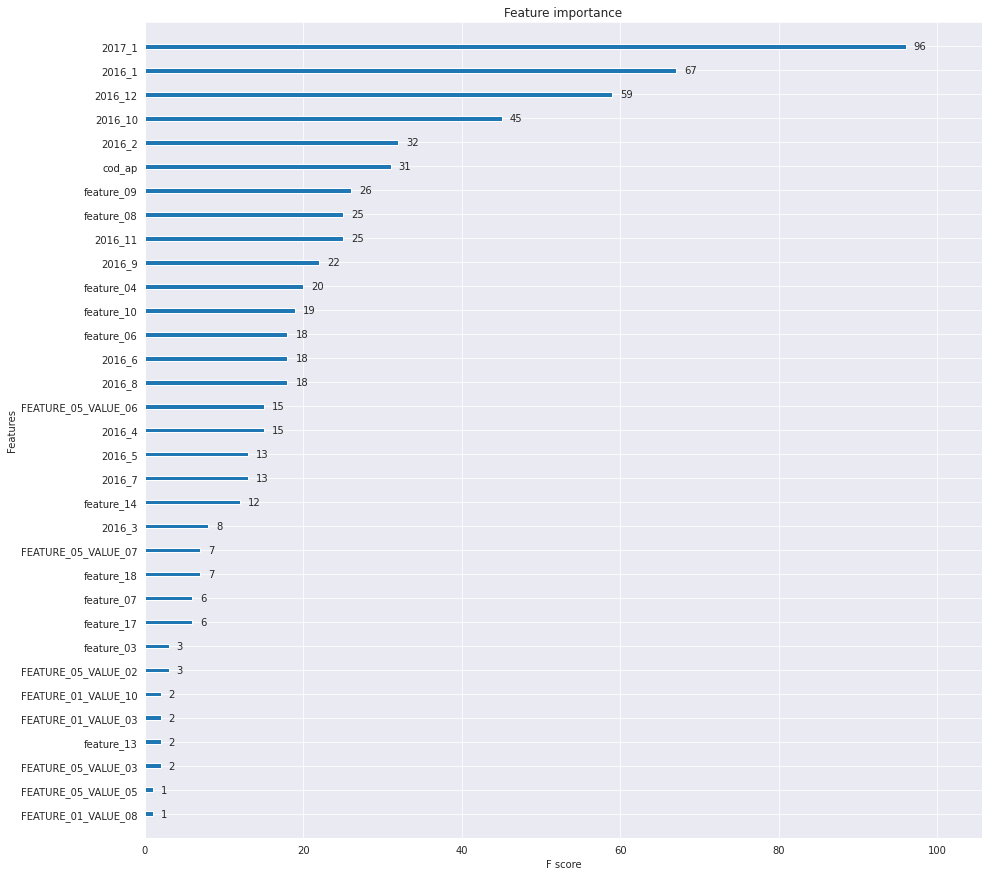

In [80]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_fev, ax=ax)
plt.show()


In [81]:
removed_nan = all_data.dropna(0,subset=["2017_3"])

In [82]:
features = ['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9','2017_1','2017_2', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = removed_nan[features]
target = ['2017_3']
Y = removed_nan[target]

In [83]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [84]:
model_mar = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
score = cross_val_score(model_mar, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(np.sqrt(-score))

Scores: [110.51981138 119.09307303 108.9291671  111.57119457 115.06512396]
Mean: 113.03567400696355
Standard deviation: 3.637263085879724


In [85]:
model_mar = model_mar.fit(X_train, y_train)
y_pred = model_mar.predict(X_test)
mean_squared_error(y_test,y_pred)

175804271.49670225

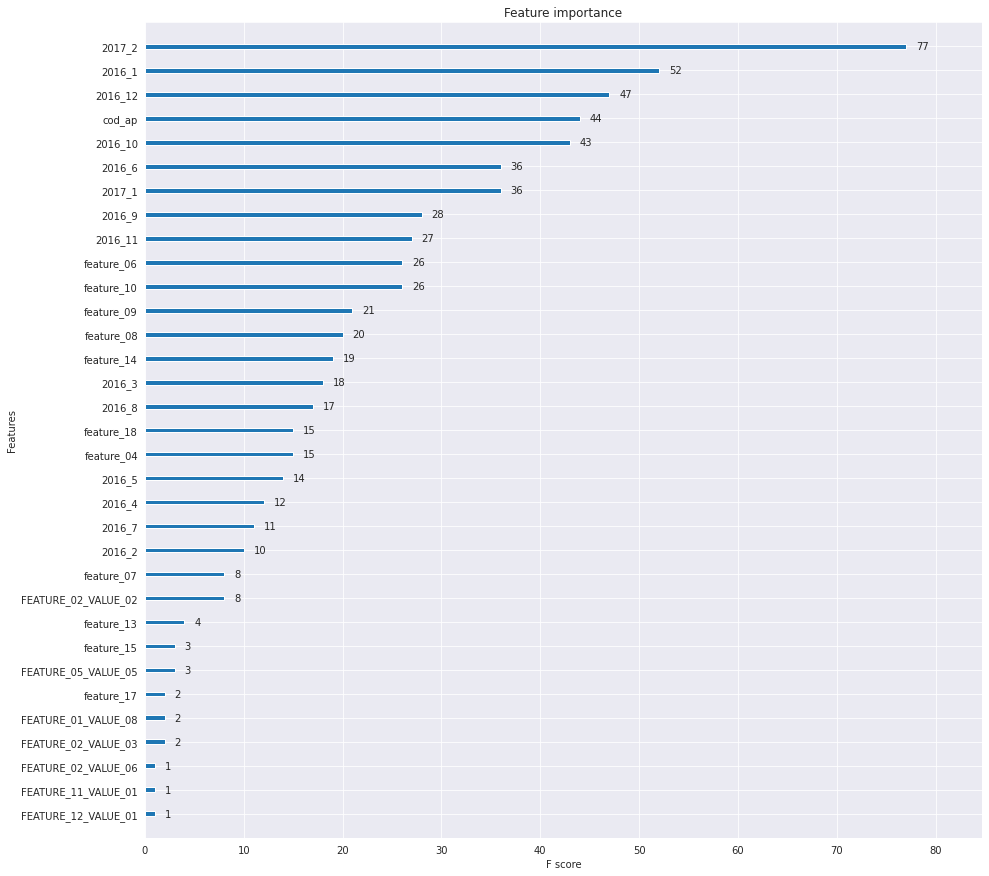

In [86]:
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_mar, ax=ax)
plt.show()


In [87]:
sub = pd.DataFrame(columns=["cod_loja","faturamento","jan","fev","mar"])

In [88]:
sub["cod_loja"] = all_data["cod_loja"].values
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN


In [89]:
features = ['2017_1', '2017_10','2017_11', '2017_12', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6',
       '2017_7', '2017_8', '2017_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = all_data[features]

In [90]:
# Only to fix predict
X.columns = ['2016_1', '2016_10','2016_11', '2016_12', '2016_2', '2016_3', '2016_4', '2016_5', '2016_6',
       '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']

In [91]:
sub["jan"] = model_jan.predict(X)
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,512148.968750,NaN,NaN
1,2,NaN,50380.738281,NaN,NaN
2,3,NaN,131367.843750,NaN,NaN
3,4,NaN,50046.132812,NaN,NaN
4,5,NaN,165140.171875,NaN,NaN


In [92]:
features = ['2017_1', '2017_10','2017_11', '2017_12', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6',
       '2017_7', '2017_8', '2017_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = all_data[features]

In [93]:
X["2018"] = sub["jan"].values
X.head()

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,2017_1,2017_10,2017_11,2017_12,2017_2,2017_3,2017_4,2017_5,2017_6,2017_7,...,FEATURE_11_VALUE_01,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,2018
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,0,0,0,0,0,512148.968750
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,0,0,0,0,0,50380.738281
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,0,0,0,0,0,131367.843750
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,0,0,0,0,0,50046.132812
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,1,0,0,0,0,0,1,0,165140.171875


In [94]:
X.columns

Index(['2017_1', '2017_10', '2017_11', '2017_12', '2017_2', '2017_3', '2017_4',
       '2017_5', '2017_6', '2017_7', '2017_8', '2017_9', 'cod_ap',
       'cod_municipio', 'feature_03', 'feature_04', 'feature_06', 'feature_07',
       'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18',
       'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08',
       'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03',
       'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01',
       'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04',
       'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07',
       'FEATURE_05_VALUE_08', 'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02',
       'FEATURE_11_VALUE_03', 'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05',
       'FEATURE_11_VALUE_06', 'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01',
       'FEATURE_12_VALUE_

In [95]:
# Only to fix predict
X.columns = ['2016_1', '2016_10','2016_11', '2016_12', '2016_2', '2016_3', '2016_4', '2016_5', '2016_6',
       '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02','2017_1']
X.head()

,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_11_VALUE_01,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,2017_1
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,0,0,0,0,0,512148.968750
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,0,0,0,0,0,50380.738281
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,0,0,0,0,0,131367.843750
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,0,0,0,0,0,50046.132812
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,1,0,0,0,0,0,1,0,165140.171875


In [96]:
X_order_fixed = X[['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9','2017_1', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']]

In [97]:
sub["fev"] = model_fev.predict(X_order_fixed)
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,512148.968750,433700.937500,NaN
1,2,NaN,50380.738281,43240.128906,NaN
2,3,NaN,131367.843750,118416.679688,NaN
3,4,NaN,50046.132812,41786.242188,NaN
4,5,NaN,165140.171875,139044.687500,NaN


In [98]:
features = ['2017_1', '2017_10','2017_11', '2017_12', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6',
       '2017_7', '2017_8', '2017_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']
X = all_data[features]

In [99]:
X["2018_jan"] = sub["jan"].values
X["2018_fev"] = sub["fev"].values
X.head()

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,2017_1,2017_10,2017_11,2017_12,2017_2,2017_3,2017_4,2017_5,2017_6,2017_7,...,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,2018_jan,2018_fev
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,0,0,0,0,512148.968750,433700.937500
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,0,0,0,0,50380.738281,43240.128906
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,0,0,0,0,131367.843750,118416.679688
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,0,0,0,0,50046.132812,41786.242188
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,1,0,0,0,0,0,1,0,165140.171875,139044.687500


In [100]:
# Only to fix predict
X.columns = ['2016_1', '2016_10','2016_11', '2016_12', '2016_2', '2016_3', '2016_4', '2016_5', '2016_6',
       '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02','2017_1','2017_2']
X.head()

,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,2017_1,2017_2
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,0,0,0,0,512148.968750,433700.937500
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,0,0,0,0,50380.738281,43240.128906
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,0,0,0,0,131367.843750,118416.679688
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,0,0,0,0,50046.132812,41786.242188
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,1,0,0,0,0,0,1,0,165140.171875,139044.687500


In [101]:
X_order_fixed = X[['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9','2017_1','2017_2', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02']]
X_order_fixed.head()

,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_05_VALUE_08,FEATURE_11_VALUE_01,FEATURE_11_VALUE_02,FEATURE_11_VALUE_03,FEATURE_11_VALUE_04,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,0,0,0,0,0,0
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,0,0,0,0,0,0
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,0,0,0,0,0,0
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,0,0,0,0,0,0
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,0,1,0,0,0,0,0,1,0


In [102]:
sub["mar"] = model_mar.predict(X_order_fixed)
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,512148.968750,433700.937500,553236.625000
1,2,NaN,50380.738281,43240.128906,57973.945312
2,3,NaN,131367.843750,118416.679688,155387.359375
3,4,NaN,50046.132812,41786.242188,55250.265625
4,5,NaN,165140.171875,139044.687500,171592.328125


In [103]:
sub["faturamento"] = (sub["jan"].values + sub["fev"].values + sub["mar"].values)/3
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,499695.500000,512148.968750,433700.937500,553236.625000
1,2,50531.605469,50380.738281,43240.128906,57973.945312
2,3,135057.296875,131367.843750,118416.679688,155387.359375
3,4,49027.546875,50046.132812,41786.242188,55250.265625
4,5,158592.390625,165140.171875,139044.687500,171592.328125


In [104]:
sub["faturamento"].sum()

305686080.0

In [107]:
sub.to_csv("./results/sub_1_v1.csv")

In [108]:
desafio_1 = sub[["cod_loja","faturamento"]]
desafio_1.head()

,cod_loja,faturamento
0,1,499695.500000
1,2,50531.605469
2,3,135057.296875
3,4,49027.546875
4,5,158592.390625


In [109]:
desafio_1.to_csv("./results/desafio_1_v1.csv",index=False,sep=";")

### Usando os dados de lojas atuais, meses e os metadados de população e IDH

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Scores: [14141.01408717 15908.1715287  21792.80596134 15798.81128326
 16409.58403059]
Mean: 16810.077378211972
Standard deviation: 2605.6849841229287
230992949.11998603


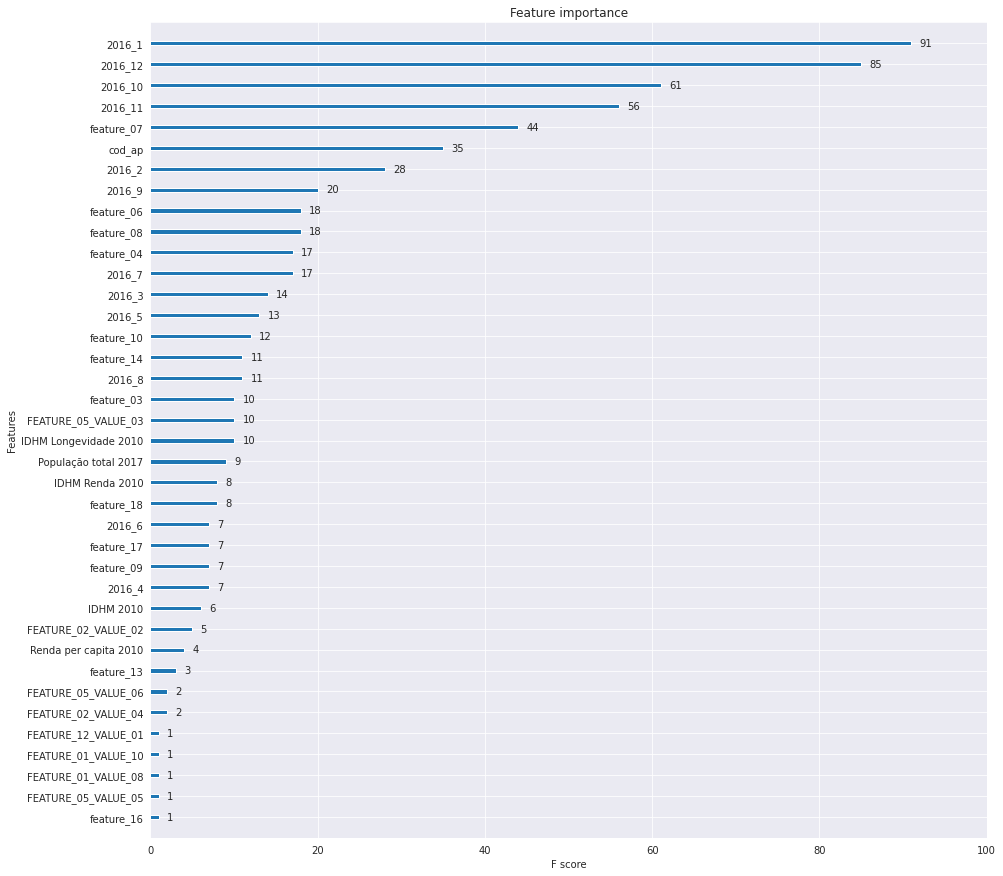

In [134]:
removed_nan = all_data.dropna(0,subset=["2017_1"])
features = ['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
       'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']
X = removed_nan[features]
target = ['2017_1']
Y = removed_nan[target]
X['População total 2017'] = X['População total 2017'].astype(float)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model_jan = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
score = cross_val_score(model_jan, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(-score)
model_jan = model_jan.fit(X_train, y_train)
y_pred = model_jan.predict(X_test)
print(mean_squared_error(y_test,y_pred))
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_jan, ax=ax)
plt.show()


/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Scores: [10151.56196839 10862.7012887  11339.92196898 10828.01590138
 13942.52966755]
Mean: 11424.946159000108
Standard deviation: 1314.489114366552
131160508.15286414


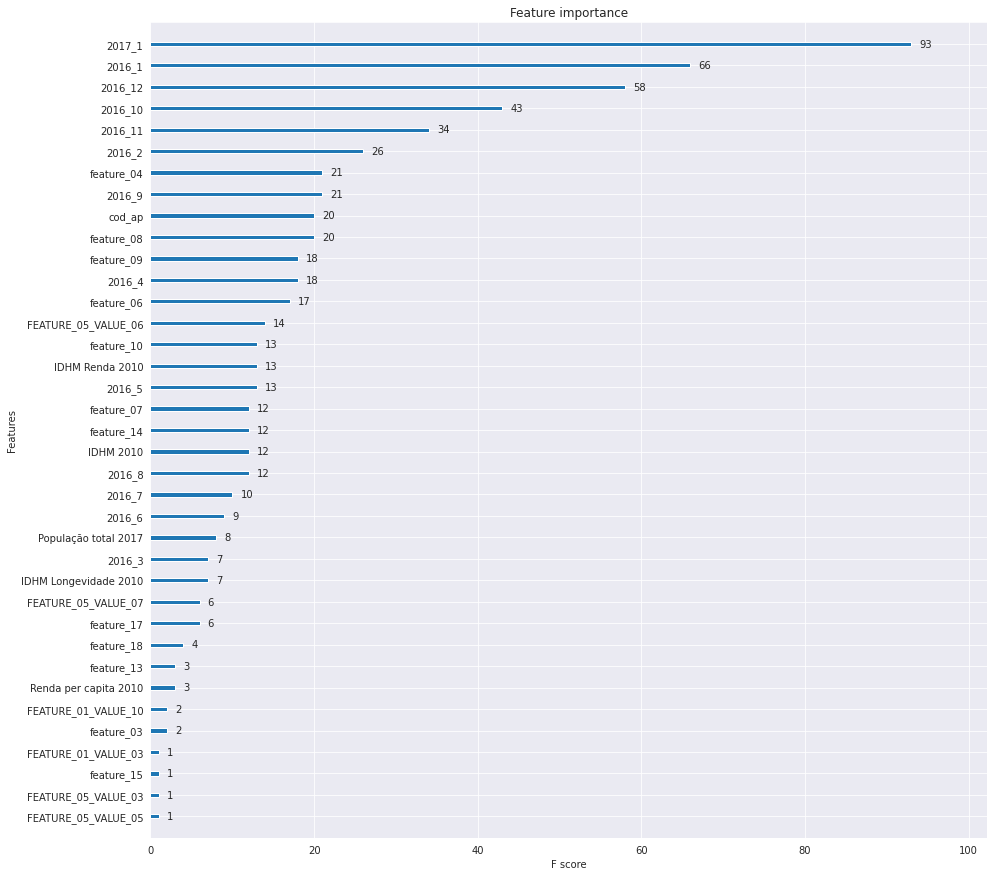

In [135]:
removed_nan = all_data.dropna(0,subset=["2017_2"])
features = ['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9', '2017_1','cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
       'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']
X = removed_nan[features]
target = ['2017_2']
Y = removed_nan[target]
X['População total 2017'] = X['População total 2017'].astype(float)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model_fev = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
score = cross_val_score(model_fev, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(-score)
model_fev = model_fev.fit(X_train, y_train)
y_pred = model_fev.predict(X_test)
print(mean_squared_error(y_test,y_pred))
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_fev, ax=ax)
plt.show()


/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Scores: [12244.82417702 14160.56725166 11783.69946938 12453.57661892
 13236.72101289]
Mean: 12775.877705973513
Standard deviation: 836.66662249143
175440242.04324186


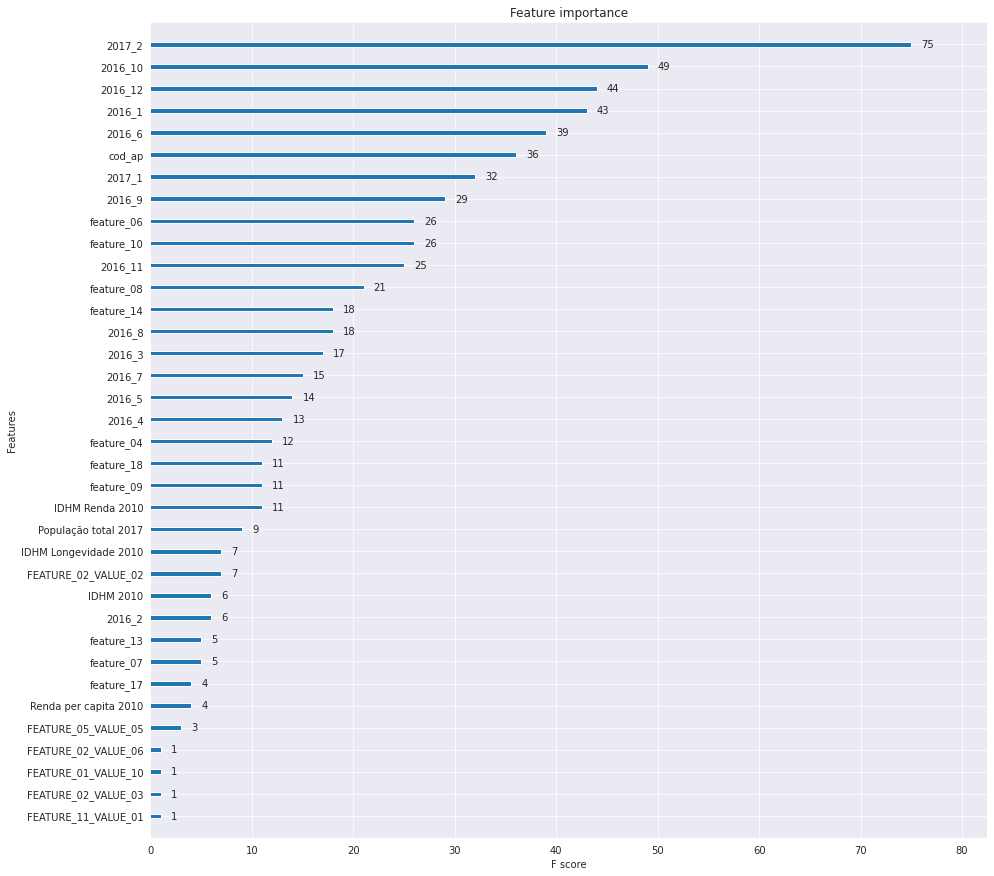

In [136]:
removed_nan = all_data.dropna(0,subset=["2017_3"])
features = ['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9', '2017_1','2017_2','cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
       'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']
X = removed_nan[features]
target = ['2017_3']
Y = removed_nan[target]
X['População total 2017'] = X['População total 2017'].astype(float)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model_mar = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
score = cross_val_score(model_mar, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
display_scores(-score)
model_mar = model_mar.fit(X_train, y_train)
y_pred = model_mar.predict(X_test)
print(mean_squared_error(y_test,y_pred))
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(model_mar, ax=ax)
plt.show()


In [137]:
sub = pd.DataFrame(columns=["cod_loja","faturamento","jan","fev","mar"])
sub["cod_loja"] = all_data["cod_loja"].values
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN


In [138]:
features = ['2017_1', '2017_10','2017_11', '2017_12', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6',
       '2017_7', '2017_8', '2017_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
       'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']
X = all_data[features]
X['População total 2017'] = X['População total 2017'].astype(float)

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [139]:
# Only to fix predict
X.columns = ['2016_1', '2016_10','2016_11', '2016_12', '2016_2', '2016_3', '2016_4', '2016_5', '2016_6',
       '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']

In [140]:
sub["jan"] = model_jan.predict(X)
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,520670.531250,NaN,NaN
1,2,NaN,49195.863281,NaN,NaN
2,3,NaN,131607.015625,NaN,NaN
3,4,NaN,50218.152344,NaN,NaN
4,5,NaN,165427.453125,NaN,NaN


In [141]:
features = ['2017_1', '2017_10','2017_11', '2017_12', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6',
       '2017_7', '2017_8', '2017_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']
X = all_data[features]

In [142]:
X["2018"] = sub["jan"].values
X.head()

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,2017_1,2017_10,2017_11,2017_12,2017_2,2017_3,2017_4,2017_5,2017_6,2017_7,...,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,População total 2017,IDHM 2010,IDHM Renda 2010,IDHM Longevidade 2010,Renda per capita 2010,2018
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,307530,0.758,0.749,0.859,846.93,520670.531250
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,3039444,0.824,0.863,0.873,1715.11,49195.863281
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,12106920,0.805,0.843,0.855,1516.21,131607.015625
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,41907,0.699,0.691,0.842,588.20,50218.152344
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,0,1,0,474706,0.733,0.723,0.820,717.88,165427.453125


In [143]:
X.columns

Index(['2017_1', '2017_10', '2017_11', '2017_12', '2017_2', '2017_3', '2017_4',
       '2017_5', '2017_6', '2017_7', '2017_8', '2017_9', 'cod_ap',
       'cod_municipio', 'feature_03', 'feature_04', 'feature_06', 'feature_07',
       'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18',
       'FEATURE_01_VALUE_03', 'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08',
       'FEATURE_01_VALUE_10', 'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03',
       'FEATURE_02_VALUE_04', 'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01',
       'FEATURE_05_VALUE_02', 'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04',
       'FEATURE_05_VALUE_05', 'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07',
       'FEATURE_05_VALUE_08', 'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02',
       'FEATURE_11_VALUE_03', 'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05',
       'FEATURE_11_VALUE_06', 'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01',
       'FEATURE_12_VALUE_

In [147]:
# Only to fix predict
X.columns = ['2016_1', '2016_10','2016_11', '2016_12', '2016_2', '2016_3', '2016_4', '2016_5', '2016_6',
       '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02','População total 2017', 'IDHM 2010',
       'IDHM Renda 2010', 'IDHM Longevidade 2010', 'Renda per capita 2010','2017_1']
X['População total 2017'] = X['População total 2017'].astype(float)
X.head()

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,População total 2017,IDHM 2010,IDHM Renda 2010,IDHM Longevidade 2010,Renda per capita 2010,2017_1
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,307530.0,0.758,0.749,0.859,846.93,520670.531250
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,3039444.0,0.824,0.863,0.873,1715.11,49195.863281
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,12106920.0,0.805,0.843,0.855,1516.21,131607.015625
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,41907.0,0.699,0.691,0.842,588.20,50218.152344
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,0,1,0,474706.0,0.733,0.723,0.820,717.88,165427.453125


In [148]:
X_order_fixed = X[['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9','2017_1', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017', 'IDHM 2010',
       'IDHM Renda 2010', 'IDHM Longevidade 2010', 'Renda per capita 2010']]

In [149]:
sub["fev"] = model_fev.predict(X_order_fixed)
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,520670.531250,433214.156250,NaN
1,2,NaN,49195.863281,42203.675781,NaN
2,3,NaN,131607.015625,117840.289062,NaN
3,4,NaN,50218.152344,41423.875000,NaN
4,5,NaN,165427.453125,137312.156250,NaN


In [151]:
features = ['2017_1', '2017_10','2017_11', '2017_12', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6',
       '2017_7', '2017_8', '2017_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']
X = all_data[features]
X["2018_jan"] = sub["jan"].values
X["2018_fev"] = sub["fev"].values
X.head()

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,2017_1,2017_10,2017_11,2017_12,2017_2,2017_3,2017_4,2017_5,2017_6,2017_7,...,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,População total 2017,IDHM 2010,IDHM Renda 2010,IDHM Longevidade 2010,Renda per capita 2010,2018_jan,2018_fev
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,307530,0.758,0.749,0.859,846.93,520670.531250,433214.156250
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,3039444,0.824,0.863,0.873,1715.11,49195.863281,42203.675781
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,12106920,0.805,0.843,0.855,1516.21,131607.015625,117840.289062
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,41907,0.699,0.691,0.842,588.20,50218.152344,41423.875000
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,1,0,474706,0.733,0.723,0.820,717.88,165427.453125,137312.156250


In [154]:
# Only to fix predict
X.columns = ['2016_1', '2016_10','2016_11', '2016_12', '2016_2', '2016_3', '2016_4', '2016_5', '2016_6',
       '2016_7', '2016_8', '2016_9', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
        'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010',
        '2017_1','2017_2']
X['População total 2017'] = X['População total 2017'].astype(float)
X.head()

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,População total 2017,IDHM 2010,IDHM Renda 2010,IDHM Longevidade 2010,Renda per capita 2010,2017_1,2017_2
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,307530.0,0.758,0.749,0.859,846.93,520670.531250,433214.156250
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,3039444.0,0.824,0.863,0.873,1715.11,49195.863281,42203.675781
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,12106920.0,0.805,0.843,0.855,1516.21,131607.015625,117840.289062
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,41907.0,0.699,0.691,0.842,588.20,50218.152344,41423.875000
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,1,0,474706.0,0.733,0.723,0.820,717.88,165427.453125,137312.156250


In [156]:
X_order_fixed = X[['2016_1', '2016_10', '2016_11', '2016_12', '2016_2', '2016_3', '2016_4',
       '2016_5', '2016_6', '2016_7', '2016_8', '2016_9','2017_1','2017_2', 'cod_ap', 'cod_municipio',
       'feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08',
       'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'FEATURE_01_VALUE_03',
       'FEATURE_01_VALUE_06', 'FEATURE_01_VALUE_08', 'FEATURE_01_VALUE_10',
       'FEATURE_02_VALUE_02', 'FEATURE_02_VALUE_03', 'FEATURE_02_VALUE_04',
       'FEATURE_02_VALUE_06', 'FEATURE_05_VALUE_01', 'FEATURE_05_VALUE_02',
       'FEATURE_05_VALUE_03', 'FEATURE_05_VALUE_04', 'FEATURE_05_VALUE_05',
       'FEATURE_05_VALUE_06', 'FEATURE_05_VALUE_07', 'FEATURE_05_VALUE_08',
       'FEATURE_11_VALUE_01', 'FEATURE_11_VALUE_02', 'FEATURE_11_VALUE_03',
       'FEATURE_11_VALUE_04', 'FEATURE_11_VALUE_05', 'FEATURE_11_VALUE_06',
       'FEATURE_11_VALUE_07', 'FEATURE_12_VALUE_01', 'FEATURE_12_VALUE_02',
         'População total 2017','IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','Renda per capita 2010']]
X_order_fixed.head()

,2016_1,2016_10,2016_11,2016_12,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,...,FEATURE_11_VALUE_05,FEATURE_11_VALUE_06,FEATURE_11_VALUE_07,FEATURE_12_VALUE_01,FEATURE_12_VALUE_02,População total 2017,IDHM 2010,IDHM Renda 2010,IDHM Longevidade 2010,Renda per capita 2010
0,404108.77,637339.76,891173.22,1216996.84,483610.18,626291.59,612062.60,748281.98,700312.65,646369.23,...,0,0,0,0,0,307530.0,0.758,0.749,0.859,846.93
1,55235.99,59996.08,76670.53,92232.32,39019.13,62446.56,52944.17,86638.16,76081.09,60697.95,...,0,0,0,0,0,3039444.0,0.824,0.863,0.873,1715.11
2,131512.12,143691.35,204050.94,420197.90,130868.47,141768.81,134988.33,220139.70,202257.56,132580.46,...,0,0,0,0,0,12106920.0,0.805,0.843,0.855,1516.21
3,48694.93,46064.16,64706.32,173683.70,42445.06,51014.55,44013.26,66607.47,59034.85,42618.25,...,0,0,0,0,0,41907.0,0.699,0.691,0.842,588.20
4,192211.08,173597.75,203650.34,412462.37,151167.08,177428.43,169632.23,285896.56,246040.77,177883.45,...,0,0,0,1,0,474706.0,0.733,0.723,0.820,717.88


In [157]:
sub["mar"] = model_mar.predict(X_order_fixed)
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,NaN,520670.531250,433214.156250,551241.187500
1,2,NaN,49195.863281,42203.675781,59512.589844
2,3,NaN,131607.015625,117840.289062,155677.562500
3,4,NaN,50218.152344,41423.875000,55303.230469
4,5,NaN,165427.453125,137312.156250,170234.546875


In [158]:
sub["faturamento"] = (sub["jan"].values + sub["fev"].values + sub["mar"].values)/3
sub.head()

,cod_loja,faturamento,jan,fev,mar
0,1,501708.625000,520670.531250,433214.156250,551241.187500
1,2,50304.042969,49195.863281,42203.675781,59512.589844
2,3,135041.625000,131607.015625,117840.289062,155677.562500
3,4,48981.753906,50218.152344,41423.875000,55303.230469
4,5,157658.062500,165427.453125,137312.156250,170234.546875


In [159]:
sub["faturamento"].sum()

305628030.0

In [160]:
sub.to_csv("./results/sub_1_v2.csv")

In [161]:
desafio_1 = sub[["cod_loja","faturamento"]]
desafio_1.head()

,cod_loja,faturamento
0,1,501708.625000
1,2,50304.042969
2,3,135041.625000
3,4,48981.753906
4,5,157658.062500


In [162]:
desafio_1.to_csv("./results/desafio_1_v2.csv",index=False,sep=";")